# Thermo-mechanical subduction with UWGeodynamics

Notes:

* This currently relies on the UWGeodynamics branch of UWSubduction, 
    * in this branch I've removed all references to TectonicModel
* Q2 for Stokes, Q1 for Heat?

* Currently solver is not converging for the composite rheology, 
* Expose the full solver, but retain the `run_for` function
    * I've tried to do this but possible failed


In [1]:
import UWGeodynamics as GEO
import glucifer
import numpy as np

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
import sys

#this does't actually need to be protected. More a reminder it's an interim measure
sys.path.append('../UWsubduction/')

import UWsubduction as usub

In [3]:
#GEO.uw.function.math.abs

In [4]:
u = GEO.UnitRegistry

In [5]:
model_length = 1000. * u.kilometer
refDensity = 3300. * u.kilogram / u.meter**3
refViscosity = 1e20 * u.pascal * u.second
refDiffusivity = 1e-6 *u.metre**2 / u.second                   #thermal diffusivity
surfaceTemp = 273.15 * u.degK
potentialTemp = 1603.15 * u.degK

KL = model_length
Kt = KL**2/refDiffusivity
KM = refViscosity * KL * Kt
KT = potentialTemp - surfaceTemp


GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

In [6]:
Model = GEO.Model(elementRes=(64*4, 64), 
                  minCoord=(-2000. * u.kilometer,  0. * u.kilometer), 
                  maxCoord=(2000. * u.kilometer, 1000. * u.kilometer),
                  periodic = [True, False],
                  gravity=(0.0, -10. * u.meter / u.second**2))

In [7]:
Model.outputDir = "sub_test1"

In [8]:
## initialize geometries

mantleShape = GEO.shapes.Layer2D(top=Model.top, bottom=Model.bottom)


In [9]:
## Materials


mantle = Model.add_material(name="Upper Mantle", shape=mantleShape)
interface  = Model.add_material(name="Upper Slab")

In [10]:
print interface.index
print mantle.index

2
1


In [11]:
#Model.materialField.

## Boundary conds.

In [12]:
VelocityBCs = Model.set_velocityBCs(left=[0., None], 
                                    right=[0.,None], 
                                    top=[None,0.], 
                                    bottom=[None,0.])
BoundaryBCs = Model.set_temperatureBCs(top=surfaceTemp, 
                                       bottom=potentialTemp, 
                                       left=potentialTemp,
                                       right=potentialTemp)


In [13]:
#Model.set_temperatureBCs?

## Material Properties 

In [14]:
## Limits in mantle visc?

## Temp ICs

In [15]:
ageSlab = 50.*u.megayear
fractionUpperPlate = 0.2


xabs = GEO.uw.function.math.abs(Model.x)

linearFn = 1. - 1.*(xabs/(1*Model.mesh.maxCoord[0]))
cosineFn = usub.cosine_taper(-Model.x, 
                        GEO.nonDimensionalize(-50.*u.kilometer), 
                        GEO.nonDimensionalize(100.*u.kilometer))

range2 = 1 - fractionUpperPlate;
cosineFn = (cosineFn*range2) + fractionUpperPlate

ageFn = linearFn*cosineFn*GEO.nonDimensionalize(ageSlab)

In [16]:
#GEO.nonDimensionalize(Model.top)

In [17]:
depthFn = GEO.nonDimensionalize(Model.top) - Model.y

In [18]:
plateTempFn = 1.*GEO.uw.function.math.erf((depthFn)/(2.*GEO.uw.function.math.sqrt(1.*ageFn))) + GEO.nonDimensionalize(surfaceTemp)





In [19]:
#.nonDimensionalize(potentialTemp), GEO.nonDimensionalize(surfaceTemp)


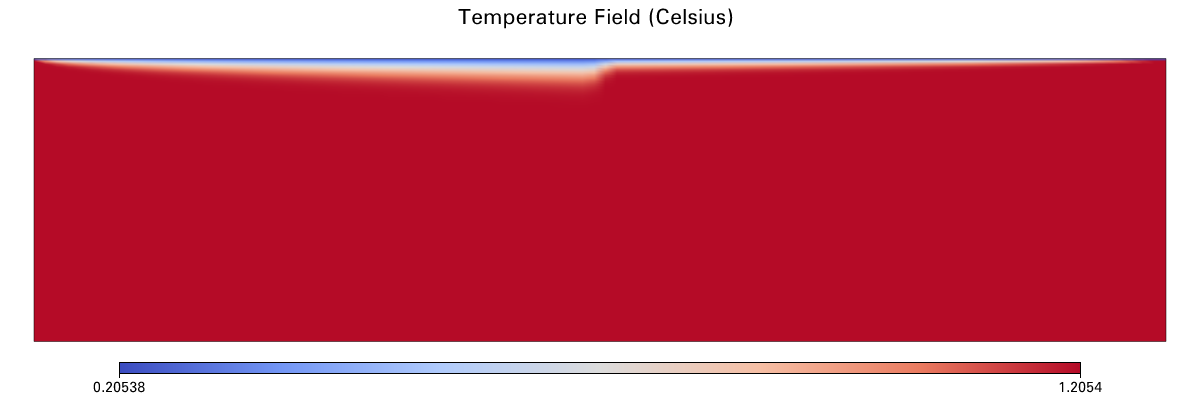

In [20]:
Fig = glucifer.Figure(figsize=(1200,400), title="Temperature Field (Celsius)", quality=3)
Fig.Surface(Model.mesh, plateTempFn, colours="coolwarm")
Fig.show()

In [21]:
#Model.swarm


## Set up slab bit

In [22]:
szloc = GEO.nonDimensionalize(0.*u.kilometer)
radiusOfCurv = GEO.nonDimensionalize(250.*u.kilometer)
normal = [1.0, 0]
ds = GEO.nonDimensionalize(2.*u.kilometer)
maxDepth = GEO.nonDimensionalize(150.*u.kilometer)
vertoffset = GEO.nonDimensionalize(0.*u.kilometer)
platethickness = 2.32*np.sqrt(1.*GEO.nonDimensionalize(ageSlab) )
modelLeftBound = GEO.nonDimensionalize(Model.minCoord[0])

def circGradientFn(S):
    if S == 0.:
        return 0.
    elif S < radiusOfCurv:
        return max(-S/np.sqrt((radiusOfCurv**2 - S**2)), -1e3)
    else:
        return -1e5

In [23]:
#platethickness

In [24]:
slabTopData = usub.slab_top(
    [szloc, 1.0 - vertoffset], 
    normal, 
    circGradientFn, 
    ds, 
    maxDepth - vertoffset - ds, 
    Model.mesh)





slabTop = usub.interface2D(Model.mesh, 
                      Model.velocityField, 
                      slabTopData[:,0], 
                      slabTopData[:,1],
                      platethickness, 
                      1,
                      insidePt=[modelLeftBound/4, 0.5])

In [25]:
#slabTopData[:,1]

In [26]:
signedDistanceVar = Model.add_swarm_variable('dummy1')
proxyTempVar = Model.add_swarm_variable('dummy2')

signedDistanceVar.data[:] = 1.0
proxyTempVar.data[:] = 1.0
proxyTempVar.data[:] = plateTempFn.evaluate(Model.swarm)

In [27]:
#signedDistanceVar
#slabTop.thickness

In [28]:
sd, pts = slabTop.compute_signed_distance(
    Model.swarm.particleCoordinates.data, 
    distance=slabTop.thickness)
    
    
signedDistanceVar.data[np.logical_and(sd>0, sd<=slabTop.thickness)] = \
sd[np.logical_and(sd>0, sd<=slabTop.thickness)]

In [29]:
#slabTempProx  = potentialTemp*fn.math.erf((tmUwMap.signedDistanceVar)/(2.*np.sqrt(1.*slabAge)))
age = GEO.nonDimensionalize(ageSlab)

slabTempProx = 1.*GEO.uw.function.math.erf(
    (signedDistanceVar)/(2.*GEO.uw.function.math.sqrt(1.*age)))  \
    + GEO.nonDimensionalize(surfaceTemp)


slabTempProxData = slabTempProx.evaluate(Model.swarm)
proxyTempVarCopy = proxyTempVar.data.copy()
proxyTempVar.data[:] = np.minimum(proxyTempVarCopy, slabTempProxData)




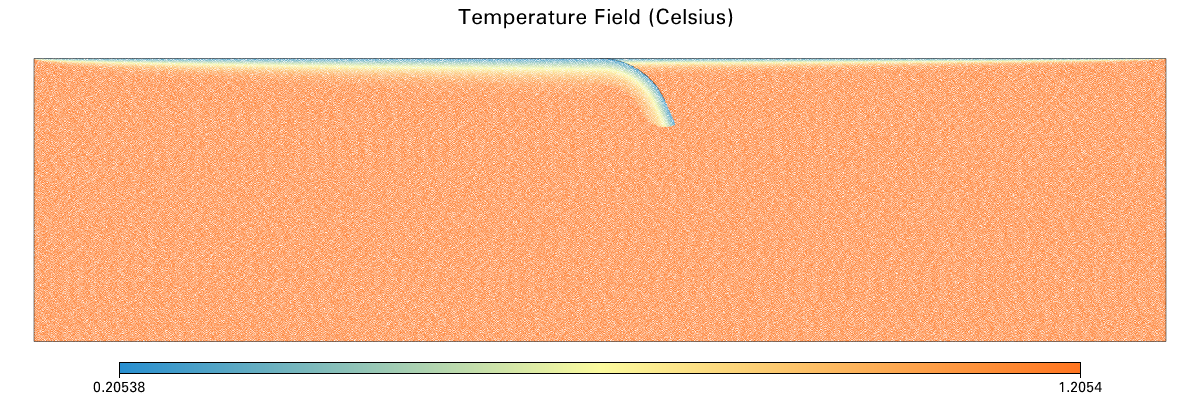

In [30]:
Fig = glucifer.Figure(figsize=(1200,400), title="Temperature Field (Celsius)", quality=3)
#Fig.Surface(Model.mesh, plateTempFn, colours="coolwarm")
Fig.Points(Model.swarm, proxyTempVar)
Fig.Points(slabTop.swarm)


Fig.show()

In [31]:
#slabTop.swarm.particleGlobalCount

In [32]:
## Need a restart Flag here
projectorMeshTemp= GEO.uw.utils.MeshVariable_Projection( 
    Model.temperature, 
    proxyTempVar , 
    type=0 )

projectorMeshTemp.solve()




# Set material data for the weak layer

In [33]:

plateDataXs = np.arange(modelLeftBound + ds, szloc + ds, ds)
plateDataYs = (1.0 - vertoffset)*np.ones(len(plateDataXs))
plateData = np.column_stack((plateDataXs, plateDataYs))

#exclude the first point in the slab top, as it appears in plate data
slabTopData = np.row_stack((plateData, slabTopData[1:,:]))

slabTop = usub.interface2D(Model.mesh, 
                      Model.velocityField, 
                      slabTopData[:,0], 
                      slabTopData[:,1],
                      platethickness, 
                      1,
                      insidePt=[modelLeftBound/4, 0.5])

In [34]:
sd, pts = slabTop.compute_signed_distance(
    Model.swarm.particleCoordinates.data, 
    distance=slabTop.thickness)


weakLayerThickness = GEO.nonDimensionalize(10.*u.kilometer)
mask = np.logical_and(sd>0, sd<=weakLayerThickness)

Model.materialField.data[mask] = interface.index

In [35]:
interface.index


2

# Material properties

In [36]:
Model.maxViscosity = refViscosity*1e4
Model.minViscosity = refViscosity*1e-2


rh = GEO.ViscousCreepRegistry()


#Interface
interface.density =  GEO.LinearDensity(3300. * u.kilogram / u.metre**3, thermalExpansivity=3.0e-5 / u.degK)
interface.diffusivity =  1e-6 * u.metre**2 / u.second 
interface.viscosity = 1e19 * u.pascal * u.second


#Mantle
mantle.diffusivity = 1e-6 * u.metre**2 / u.second 
mantle.density = GEO.LinearDensity(3300. * u.kilogram / u.metre**3, thermalExpansivity=3.0e-5 / u.degK)

mantle.viscosity  = 1.0 * rh.Dry_Olivine_Dislocation_Karato_and_Wu_1990
mantle.plasticity   = GEO.VonMises(cohesion=50.* u.megapascal)


#mantle.plasticity = GEO.DruckerPrager(name="mantle_plasticity",
#                                         cohesion=20. * u.megapascal,
#                                         cohesionAfterSoftening=20. * u.megapascal,
#                                         frictionCoefficient=0.1,
#                                         frictionAfterSoftening=0.1,
#                                         epsilon1=0.0, epsilon2=0.2)

In [39]:
#Model.max

## Initialize

In [38]:
Model.init_model(temperature=False)


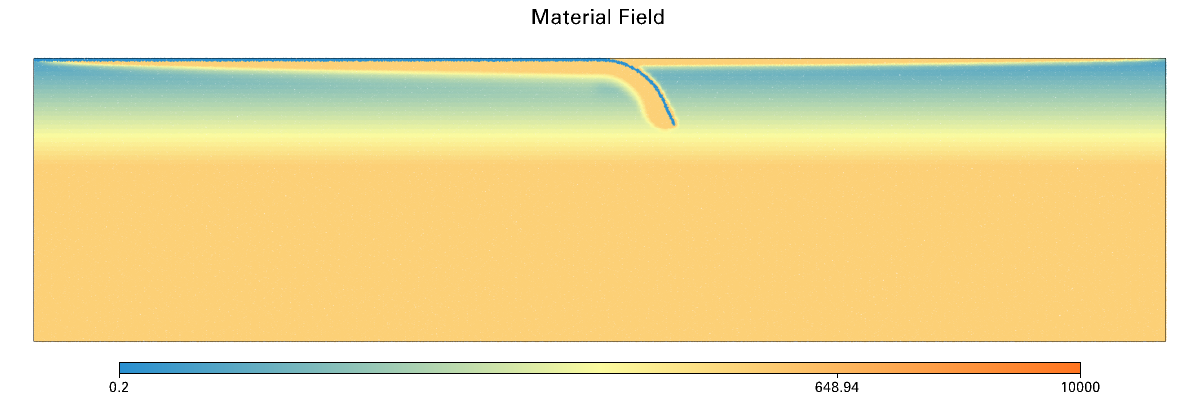

In [54]:
Fig = glucifer.Figure(figsize=(1200,400), title="Material Field", quality=2)
Fig.Points(Model.swarm, 
           Model._viscosityFn, 
           fn_size=2.0, logScale=True, valueRange = [0.2, 1e4])
Fig.show()

In [57]:
#Fig = glucifer.Figure(figsize=(1200,400), title="Test", quality=2)
#Fig.Points(Model.swarm, Model._densityFn, fn_size=2.0)
#Fig.show()

In [58]:
#np.unique(Model.materialField.data[:])

# Solve 

In [59]:
#Model._s

```

self._stokes_SLE = uw.systems.Stokes(
                    velocityField=self.velocityField,
                    pressureField=self.pressureField,
                    conditions=conditions,
                    fn_viscosity=self._viscosityFn,
                    fn_bodyforce=self._buoyancyFn,
                    fn_stresshistory=self._elastic_stressFn,
                    fn_one_on_lambda=self._lambdaFn)



    def solve(self):
        """ Solve Stokes """

        if self.step == 0:
            self._curTolerance = rcParams["initial.nonlinear.tolerance"]
            minIterations = rcParams["initial.nonlinear.min.iterations"]
            maxIterations = rcParams["initial.nonlinear.max.iterations"]
        else:
            self._curTolerance = rcParams["nonlinear.tolerance"]
            minIterations = rcParams["nonlinear.min.iterations"]
            maxIterations = rcParams["nonlinear.max.iterations"]

        self.get_stokes_solver().solve(
            nonLinearIterate=True,
            nonLinearMinIterations=minIterations,
            nonLinearMaxIterations=maxIterations,
            callback_post_solve=self.callback_post_solve,
            nonLinearTolerance=self._curTolerance)

```

In [60]:
#Model._stokes_SLE

In [61]:
#This sets up the Stokes System as Well
solver = Model.get_stokes_solver()


solver.options.scr.ksp_type = "cg"
solver.options.scr.ksp_rtol = 1.0e-4
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
#solver.options.scr.ksp_rtol = 1.0e-4

In [62]:
#solver.solve(nonLinearIterate=True)



In [ ]:
Model.run_for(100000.0 * u.years)

Running with UWGeodynamics version 1.0.1



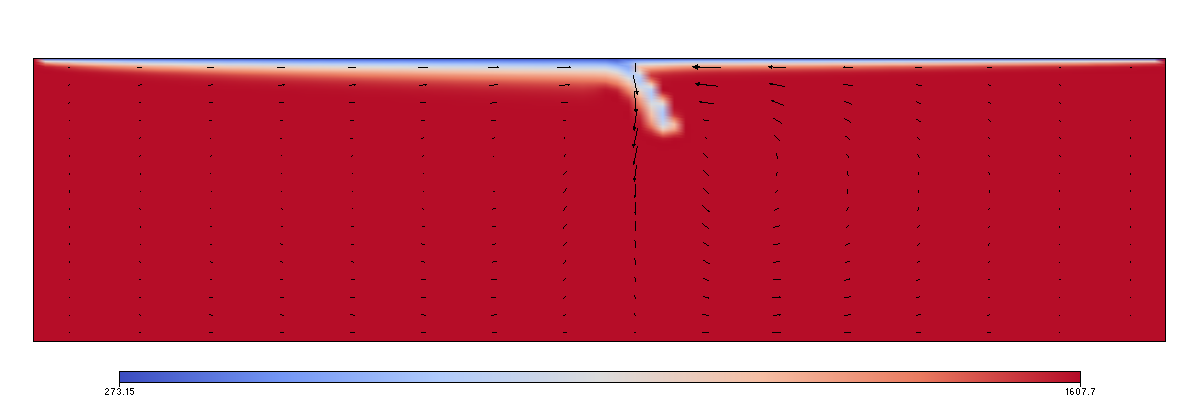

In [51]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, GEO.Dimensionalize(Model.temperature, u.degK), colours="coolwarm")
Fig.VectorArrows(Model.mesh, Model.velocityField)
#Fig.save("Figure_3.png")
Fig.show()

<Quantity(0.0, 'year')>